In [5]:
import torch
import triton
import math
from copy import deepcopy
import os
os.environ['TRITON_PRINT_AUTOTUNING'] = '1'
from dyt import DYT
from rmsnorm import TritonRMSNorm
from apex.normalization import FusedRMSNorm
from transformer_engine.pytorch.module.rmsnorm import RMSNorm as TERMSNorm

In [6]:
dtype = torch.bfloat16
device = 'cuda'
bs, seq_len, dim = 1, 2048, 8192
beta = True
x1 = torch.randn(bs, seq_len, dim, device=device, dtype=dtype)
x1.requires_grad_(True)

x2 = deepcopy(x1)
dyt1 = DYT(dim, beta=beta).to(device).to(dtype)
dyt1.gemma.data.copy_(torch.randn(dim))
if beta:
    dyt1.beta.data.copy_(torch.randn(dim))
dyt2 = deepcopy(dyt1)


In [7]:
y1 = dyt1(x1, "torch")
y2 = dyt2(x2, "triton")
dy = torch.randn_like(y1)
y1.backward(dy)
y2.backward(dy)
print((y1-y2).abs().max(), (y1-y2).abs().mean())
print((x1.grad-x2.grad).abs().max(), (x1.grad-x2.grad).abs().mean())
print((dyt1.gemma.grad-dyt2.gemma.grad).abs().max(), (dyt1.gemma.grad-dyt2.gemma.grad).abs().mean())
if beta:
    print((dyt1.beta.grad-dyt2.beta.grad).abs().max(), (dyt1.beta.grad-dyt2.beta.grad).abs().mean())
print((dyt1.alpha.grad-dyt2.alpha.grad).abs() / dyt1.alpha.grad.abs())


tensor(0.0078, device='cuda:0', dtype=torch.bfloat16, grad_fn=<MaxBackward1>) tensor(1.7695e-08, device='cuda:0', dtype=torch.bfloat16,
       grad_fn=<MeanBackward0>)
tensor(0.0078, device='cuda:0', dtype=torch.bfloat16) tensor(1.0245e-08, device='cuda:0', dtype=torch.bfloat16)
tensor(0., device='cuda:0', dtype=torch.bfloat16) tensor(0., device='cuda:0', dtype=torch.bfloat16)
tensor(0., device='cuda:0', dtype=torch.bfloat16) tensor(0., device='cuda:0', dtype=torch.bfloat16)
tensor([0.], device='cuda:0', dtype=torch.bfloat16)


bs: 8, seq_len: 1024


W0317 00:01:37.231000 41113 site-packages/torch/_dynamo/convert_frame.py:844] [3/8] torch._dynamo hit config.cache_size_limit (8)
W0317 00:01:37.231000 41113 site-packages/torch/_dynamo/convert_frame.py:844] [3/8]    function: 'torch_dyt_without_beta' (/sharedata/mdy/code/repo/mdy_triton/others/dyt/dyt.py:193)
W0317 00:01:37.231000 41113 site-packages/torch/_dynamo/convert_frame.py:844] [3/8]    last reason: 3/0: tensor 'L['x']' size mismatch at index 2. expected 1024, actual 9216
W0317 00:01:37.231000 41113 site-packages/torch/_dynamo/convert_frame.py:844] [3/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0317 00:01:37.231000 41113 site-packages/torch/_dynamo/convert_frame.py:844] [3/8] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_troubleshooting.html.


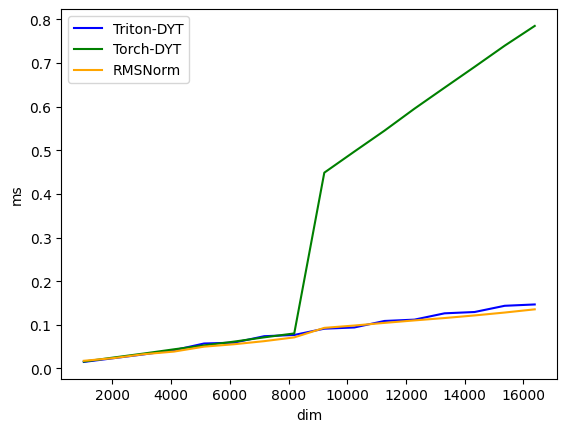

forward:
        dim  Triton-DYT  Torch-DYT   RMSNorm
0    1024.0    0.015071   0.015935  0.017661
1    2048.0    0.023701   0.025246  0.023891
2    3072.0    0.032426   0.034348  0.032826
3    4096.0    0.042000   0.043979  0.038791
4    5120.0    0.057282   0.053022  0.050070
5    6144.0    0.059244   0.061627  0.055603
6    7168.0    0.074018   0.071427  0.062683
7    8192.0    0.076847   0.080340  0.071303
8    9216.0    0.091276   0.448904  0.093149
9   10240.0    0.094061   0.497270  0.098493
10  11264.0    0.108929   0.545080  0.104551
11  12288.0    0.111998   0.595584  0.110240
12  13312.0    0.126463   0.643677  0.115669
13  14336.0    0.129491   0.691453  0.121633
14  15360.0    0.143736   0.739915  0.128260
15  16384.0    0.146797   0.785249  0.135614


In [8]:

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['dim'],  # argument names to use as an x-axis for the plot
        x_vals=[1024 * i for i in range(1, 16+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton-DYT', "Torch-DYT", 'RMSNorm'],  # possible values for `line_arg``
        line_names=[
            "Triton-DYT",
            "Torch-DYT",
            "RMSNorm"
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="forward",  # name for the plot. Used also as a file name for saving the plot.
        args={'seq_len': 1024, 'bs': 8, 'beta': False}
    ))
def benchmark(bs, seq_len, dim, beta, provider):
    device = torch.device('cuda')
    dtype = torch.bfloat16
    tensor = torch.randn(bs, seq_len, dim).to(device).to(dtype)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'Triton-DYT':
        dyt = DYT(dim, beta=beta).to(device).to(dtype)
        ms = triton.testing.do_bench(lambda: dyt(tensor, 'triton'))
    if provider == 'Torch-DYT':
        dyt = DYT(dim, beta=beta).to(device).to(dtype)
        ms = triton.testing.do_bench(lambda: dyt(tensor, 'torch'))
    if provider == 'RMSNorm':
        norm = TritonRMSNorm(dim).to(device).to(dtype)
        # norm = FusedRMSNorm(dim).to(device).to(dtype)
        # norm = TERMSNorm(dim).to(device).to(dtype)
        ms = triton.testing.do_bench(lambda: norm(tensor))
    return ms
print(f'bs: {8}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)


bs: 8, seq_len: 1024


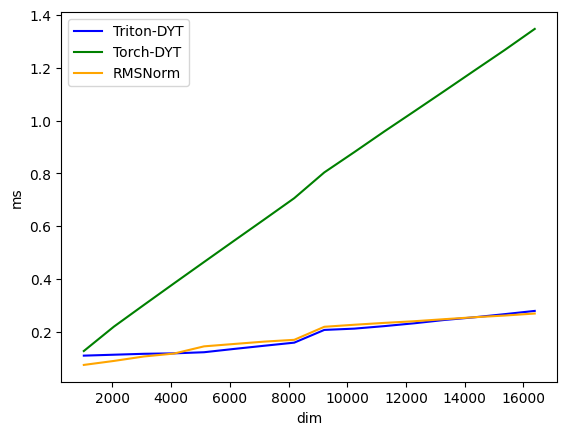

backward:
        dim  Triton-DYT  Torch-DYT   RMSNorm
0    1024.0    0.110857   0.128345  0.075739
1    2048.0    0.114352   0.220515  0.090807
2    3072.0    0.117817   0.302718  0.107729
3    4096.0    0.119450   0.384208  0.118718
4    5120.0    0.123750   0.465057  0.145998
5    6144.0    0.136245   0.545634  0.154967
6    7168.0    0.148237   0.625756  0.163894
7    8192.0    0.159987   0.706523  0.170663
8    9216.0    0.208131   0.803969  0.219986
9   10240.0    0.213040   0.880823  0.227713
10  11264.0    0.222541   0.959176  0.234750
11  12288.0    0.233347   1.035431  0.241083
12  13312.0    0.245843   1.112317  0.248811
13  14336.0    0.255996   1.189805  0.256206
14  15360.0    0.267776   1.266844  0.262506
15  16384.0    0.280046   1.346698  0.270172


In [7]:

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['dim'],  # argument names to use as an x-axis for the plot
        x_vals=[1024 * i for i in range(1, 16+1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['Triton-DYT', "Torch-DYT", 'RMSNorm'],  # possible values for `line_arg``
        line_names=[
            "Triton-DYT",
            "Torch-DYT",
            "RMSNorm"
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="backward",  # name for the plot. Used also as a file name for saving the plot.
        args={'seq_len': 1024, 'bs': 8, 'beta':False}
    ))
def benchmark(bs, seq_len, dim, beta, provider):
    device = torch.device('cuda')
    dtype = torch.bfloat16
    tensor = torch.randn(bs, seq_len, dim).to(device).to(dtype)
    tensor.requires_grad_(True)
    dy = torch.rand_like(tensor)
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'Triton-DYT':
        dyt = DYT(dim, beta=beta).to(device).to(dtype)
        y = dyt(tensor, 'triton')
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[tensor])
    if provider == 'Torch-DYT':
        dyt = DYT(dim, beta=beta).to(device).to(dtype)
        y = dyt(tensor, 'torch')
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[tensor])
    if provider == 'RMSNorm':
        norm = TritonRMSNorm(dim).to(device).to(dtype)
        # norm = FusedRMSNorm(dim).to(device).to(dtype)
        # norm = TERMSNorm(dim).to(device).to(dtype)
        y = norm(tensor)
        ms = triton.testing.do_bench(lambda: y.backward(dy, retain_graph=True), grad_to_none=[tensor])
    return ms
print(f'bs: {8}, seq_len: {1024}')
benchmark.run(show_plots=True, print_data=True)
